# pyCaret 機器學習試作

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import *
import glob

In [2]:
# 選出的五檔基金計算結果

def Calculate_funds(df, funds):

    global Drawdown, earning_strategy, earning, result
    
    # Benchmark（全部的平均）
    bench = df.loc['2019-01-04':'2020-12-31']
    bench_ret = np.log(bench/bench.shift(1))
    bench_ret = bench_ret.mean(axis = 1).to_frame()
    bench_ret.rename(columns = {0:'benchmark'}, inplace = True)

    # Result
    strategy = df.loc['2019-01-04':'2020-12-31'][funds]
    ret_strategy = np.log(strategy/strategy.shift(1))
    ret_strategy['benchmark'] = bench_ret
    ret_strategy.fillna(0, inplace = True)
    earning_strategy = ret_strategy.cumsum()
    earning = 100 * (1 + earning_strategy)
    
    # Drawdown
    Drawdown = pd.DataFrame()
    for k in earning_strategy.columns:
        strategy_ret = earning_strategy[[k]]
        li = []
        for i in range(len(strategy_ret)):
            li.append(strategy_ret.iloc[i,0] - strategy_ret.iloc[:i,0].max())
        li[0] = 0
        each_drawdown = pd.DataFrame(li, index=strategy_ret.index)
        each_drawdown.rename(columns={0:k}, inplace = True)
        for j in range(len(each_drawdown)):
            if each_drawdown.iloc[j,0] > 0:
                each_drawdown.iloc[j] = 0
        Drawdown = pd.concat([Drawdown, each_drawdown], axis = 1)
    
    # Calculate
    max_drawdown = abs(Drawdown.min())
    accumulation_return = earning_strategy.iloc[-1]
    accumulation_return.name = None
    annual_return = ret_strategy.mean() * 365
    annual_volatility = ret_strategy.std() * np.sqrt(365)
    neg_annual_volatility = ret_strategy.applymap(lambda x: 0 if x > 0 else x).std() * np.sqrt(365)
    sharpe_ratio = annual_return / annual_volatility
    sortino_ratio = annual_return / neg_annual_volatility
    calmar_ratio = annual_return / max_drawdown
    
    result = pd.DataFrame([accumulation_return, annual_return, 
                           annual_volatility, neg_annual_volatility,
                           max_drawdown, sharpe_ratio,
                           sortino_ratio, calmar_ratio],  
                          index = ['Accumulation Return', 'Annual Return',
                                   'Annual Volatility', 'Negative Annual Volatility',
                                   'Max Drawdown', 'Sharpe Ratio',
                                   'Sortino Ratio', 'Calmar Ratio']).transpose()
    return

In [3]:
path = "/Users/alex_chiang/Documents/Fin_tech/AI基金/"

files_value = sorted(glob.glob(path + 'classified/*.csv'))
files_ML = sorted(glob.glob(path + 'data_ML/*.csv'))
file_name = [i.split('/')[-1].split('.csv')[0] for i in files_ML]

In [4]:
df = pd.read_csv(files_value[8], parse_dates = True, index_col = 'Datetime')

In [5]:
df_XY = pd.read_csv(files_ML[8], parse_dates = True, index_col = ['Datetime', 'fund_id'])
df_XY.sort_index(level = 0, inplace = True)

## Setting up Environment in PyCaret

In [6]:
train_data = df_XY.iloc[:-len(df_XY.xs('2019-01-04').index)]
test_data = df_XY.iloc[-len(df_XY.xs('2019-01-04').index):]

In [7]:
dates = len(train_data.xs(train_data.xs('2019-01-03').index[0], level = 1).index)

In [8]:
setup(data = train_data, target = 'Y_ret', test_data = test_data,
      pca = True, pca_components = 3, silent = True, verbose = False)

(5,
 'lightgbm',
 False,
                     Component_1  Component_2  Component_3
 Datetime   fund_id                                       
 2019-01-04 58C        -0.214974    -0.090413    -0.061537
            58D        -0.218592    -0.096738    -0.061300
            616        -0.312404    -0.085111    -0.062909
            62C        -0.414830     0.222256    -0.061509
            62D        -0.452551     0.255030    -0.061152
            62E        -0.421003     0.227930    -0.061488
            699        -0.161740    -0.198460    -0.063692
            700        -0.212540    -0.151120    -0.064480
            715        -0.134416     0.077471    -0.067009
            71P        -0.215129     0.511777    -0.057891
            71Q        -0.209883     0.151959    -0.064035
            777        -0.222482    -0.157569    -0.054677
            778        -0.141111    -0.211885    -0.054657
            779        -0.164538    -0.195606    -0.060543
            784        -0.32691

In [9]:
# setup(data = train_data, target = 'Y_ret', pca = True, pca_components = 3, 
#       test_data = test_data, data_split_shuffle = False,
#       fold_strategy = 'timeseries', fold = (dates - 1), profile = True)

In [10]:
# 不以時間為考量（使用 K-folds）

# setup(data = train_data, target = 'Y_ret', test_data = test_data
#       pca = True, pca_components = 3)

## Comparing All Models

In [11]:
best_model = compare_models(sort = 'MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0945,0.0138,0.1131,-1.9924,0.0798,3.8331,3.2540
lightgbm,Light Gradient Boosting Machine,0.0951,0.0141,0.1150,-2.0380,0.0785,4.3204,0.1920
ada,AdaBoost Regressor,0.0975,0.0146,0.1145,-2.3012,0.0851,2.9497,0.6250
et,Extra Trees Regressor,0.0979,0.0151,0.1192,-2.2530,0.0776,5.0045,5.4560
rf,Random Forest Regressor,0.0986,0.0154,0.1205,-2.2983,0.0775,5.6549,12.3150
lr,Linear Regression,0.1024,0.0156,0.1183,-2.3478,0.0832,3.2771,0.5910
lasso,Lasso Regression,0.1024,0.0156,0.1182,-2.3451,0.0833,3.2744,0.0150
ridge,Ridge Regression,0.1024,0.0156,0.1183,-2.3478,0.0832,3.2771,0.0140
en,Elastic Net,0.1024,0.0156,0.1182,-2.3451,0.0833,3.2744,0.0140
llar,Lasso Least Angle Regression,0.1024,0.0156,0.1182,-2.3451,0.0833,3.2744,0.0140


## Tune a Model

In [12]:
tuned_best = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0665,0.0071,0.0840,0.0805,0.0566,7.5003
1,0.0770,0.0101,0.1005,-0.1457,0.0628,3.4149
2,0.0550,0.0051,0.0714,0.0371,0.0515,5.7766
3,0.0588,0.0058,0.0758,-0.6498,0.0584,4.8988
4,0.0824,0.0096,0.0980,-2.0038,0.0854,0.9905
5,0.1499,0.0276,0.1661,-6.9750,0.1385,0.8141
6,0.1022,0.0140,0.1185,-3.7453,0.0799,1.2593
7,0.1311,0.0235,0.1532,-2.4208,0.1140,2.1173
8,0.1295,0.0217,0.1474,-3.7285,0.0900,1.8079
9,0.0923,0.0128,0.1132,-0.3564,0.0723,6.8379


In [13]:
df_predict = pd.DataFrame(predict_model(tuned_best)['Label'])
df_predict.index = test_data.xs('2019-01-04').index
funds = df_predict.nlargest(5, 'Label').index

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1245,0.0189,0.1376,-9.8163,0.1177,0.8299


In [22]:
# 前五名的基金＝》計算結果
Calculate_funds(df = df, funds = funds)

In [23]:
result

,Accumulation Return,Annual Return,Annual Volatility,Negative Annual Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio
785,0.283617,0.211266,0.264001,0.165191,0.410728,0.800246,1.278917,0.514369
S40,0.179779,0.133917,0.222223,0.143051,0.373287,0.602624,0.936146,0.358751
AE6,0.181596,0.135271,0.198599,0.123319,0.351902,0.681127,1.096922,0.384399
S56,0.164879,0.122818,0.222214,0.143236,0.375374,0.552701,0.857452,0.327189
AD3,0.253771,0.189033,0.257574,0.167322,0.488087,0.733899,1.129757,0.387294
benchmark,0.241838,0.180145,0.189019,0.119846,0.348135,0.953052,1.503139,0.517457


In [24]:
earning

,785,S40,AE6,S56,AD3,benchmark
Datetime,,,,,,
2019-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-01-07,102.225038,101.442016,102.659965,101.435973,103.182794,102.120353
2019-01-08,102.884501,102.127125,102.308764,102.119052,103.198362,102.253240
2019-01-09,103.050047,102.337162,103.473130,102.327044,103.061106,103.113350
2019-01-10,103.120298,101.867995,103.080141,101.855785,102.783620,102.646937
...,...,...,...,...,...,...
2020-12-23,126.454800,116.114430,115.909986,114.638641,122.355895,121.677797
2020-12-28,126.831898,117.253513,115.909986,115.767614,122.355895,122.662149
2020-12-29,128.313923,118.729741,118.657337,117.241822,125.259303,124.354380


<AxesSubplot:xlabel='Datetime'>

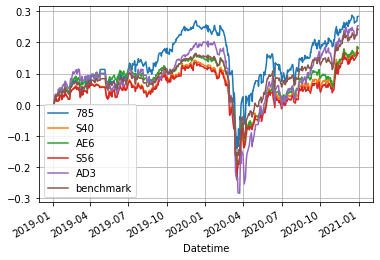

In [25]:
earning_strategy.plot(grid = True)

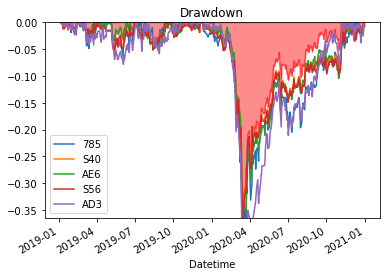

In [26]:
ax1 = Drawdown['benchmark'].plot.area(stacked=False, color = 'red', alpha=0.45, title = 'Drawdown')
ax2 = Drawdown.drop(columns = 'benchmark').plot(ax=ax1, linewidth = 1.5)
fig2 = ax2.get_figure()